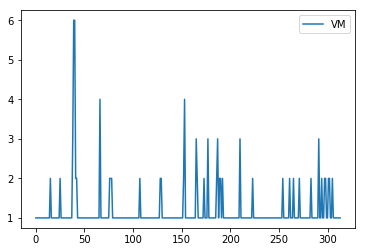

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import sklearn
import statsmodels
# import pyflux as pf
%matplotlib inline

# File_input = pd.read_table('E:/Programspace/HuaweiCodeCraft/1stRd/DemoCase/input_5flavors_cpu_7days.txt', delim_whitespace=True, header=None, names=['1','2','3'], index_col='1')
# print(File_input)
File_train = pd.read_table('E:/Programspace/HuaweiCodeCraft/1stRd/DemoCase/TrainData_2015.1.1_2015.2.19.txt', sep='\t', header=None, names=['ID','VM','Time'], index_col=False)
File_test = pd.read_table('E:/Programspace/HuaweiCodeCraft/1stRd/DemoCase/TestData_2015.2.20_2015.2.27.txt', sep='\t', header=None, names=['ID','VM','Time'], index_col=False)
# Config = pd.read_table('E:/Programspace/HuaweiCodeCraft/1stRd/DemoCase/config.txt', sep='\t', header=None, names=['VM','CPU','MEM'], index_col='VM')
# Config # Display
# # x = 'flavor10'
# # Config[Config['VM'].isin([x])]
# # Config.loc[Config['VM'].isin([x]),'CPU']
# Config_CPU = Config.set_index('VM')['CPU'].to_dict()
# Config_MEM = Config.set_index('VM')['MEM'].to_dict()
File_train.drop('ID', axis=1).groupby(by=['Time'], as_index=False).count().plot()

In [2]:
# # readin the requestment txt file
file = open('E:/Programspace/HuaweiCodeCraft/1stRd/DemoCase/input_5flavors_cpu_7days.txt')
try:
    line = file.readline()
    words = line.split(' ') # seperator is a white space
    CPU_limit = int(words[0])
    MEM_limit = int(words[1])
    
    line = file.readline() # Empty line
    
    VM_num = int(file.readline()) # numbers of different VM type
    VM_type = dict() # 
    VM_name = list()
    for i in range(VM_num):
        line = file.readline()
        words = line.split(' ')
        VM_type[words[0]] = [int(words[1]),int(words[2])]
        VM_name.append(words[0])
    
    line = file.readline()  # Empty line
    
    VM_opt = file.readline()
    
    line = file.readline() # Empty line
    
    Est_beg = file.readline()  # Prediction Period: beginning date
    Est_end = file.readline()  # end date
finally:
    file.close( )
# print(CPU_limit)
# print(MEM_limit)
# print(VM_num)
# print(VM_type)
# print(VM_opt)
# print(Data_beg)
# print(Data_end)
File_train.head()

,ID,VM,Time
0,56498c50-84e4,flavor15,2015-01-01 19:03:32
1,56498c51-8cb9,flavor15,2015-01-01 19:03:34
2,56498c52-a50e,flavor8,2015-01-01 23:26:04
3,56498c53-a241,flavor2,2015-01-02 18:25:23
4,56498c54-8528,flavor8,2015-01-02 21:03:49


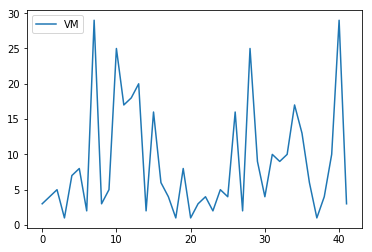

In [3]:
num = (File_train.shape)[0] # get the logged total request amount
File_train.drop('ID', axis=1)
for i in range(num):
    word = (File_train['Time'][i]).split(' ') # drop the detail time from each date
    word = word[0]
    File_train['Time'][i] = word
File_train.drop('ID', axis=1).groupby(by=['Time'], as_index=False).count().plot()

CleanedList = File_train.drop('ID', axis=1) # ID number is not a factor
# # Cleaning: drop the requested VM that is not given in input file(need not to predict)
CleanedList = CleanedList.drop([i for i in range(num) if CleanedList['VM'][i] not in VM_type]).reset_index(drop=True)
num = (CleanedList.shape)[0] # total request after cleaning
for i in range(num):
    word = (CleanedList['Time'][i]).split(' ') # drop the detail time from each date
    word = word[0]
    CleanedList['Time'][i] = word
# print(CleanedList)
Time = CleanedList['Time'].unique() # different date time
table = [Time[0],Time[-1]]
Data_beg = table[0].replace('-','').strip() # get the first date from the training file
Data_end = table[1].replace('-','').strip() # the last
# print(Data_beg,Data_end)

# # fill in the missing date
date_list=[datetime.strftime(i,'%Y-%m-%d') for i in list(pd.date_range(start=Data_beg, end=Data_end))]
# print(date_list)
date_num = len(date_list)

request_table = pd.DataFrame(data=date_list,columns=['Date'])
for i in range(VM_num):
    request_table[VM_name[i]] = 0 # Initialization 

In [4]:
# # Data fill-in to the 'request_table'
ListPackage = CleanedList.groupby(by=['Time'], as_index=False)
# request_table.loc[request_table.Date=='2015-02-01',['flavor1']] = 0
for key, group in ListPackage:
    # print('----------------------')
    # print(key)
    temp = group.groupby(by=['VM'],as_index=False).count()
    for i in range(temp.shape[0]):
        request_table.loc[request_table.Date==key,[temp.iloc[i,0]]] = temp.iloc[i,1]
        # print(temp.iloc[i,0], temp.iloc[i,1])
request_table

,Date,flavor1,flavor2,flavor3,flavor4,flavor5
0,2015-01-02,0,1,0,0,0
1,2015-01-03,0,0,0,0,0
2,2015-01-04,0,0,0,0,0
3,2015-01-05,0,0,0,0,0
4,2015-01-06,0,0,0,0,0
5,2015-01-07,0,0,0,0,0
6,2015-01-08,0,0,0,0,0
7,2015-01-09,0,0,0,0,0
8,2015-01-10,0,0,2,0,0
9,2015-01-11,0,0,0,0,0


In [5]:
window =np.ones((7,), dtype=int)
request_sum = pd.DataFrame(data=date_list[6:date_num+1], columns=['Date'])
for i in range(VM_num):
    value = np.array(request_table[VM_name[i]])# Initialization
    value = np.convolve(value, window, mode='valid')
    request_sum[VM_name[i]] = value
request_sum

,Date,flavor1,flavor2,flavor3,flavor4,flavor5
0,2015-01-08,0,1,0,0,0
1,2015-01-09,0,0,0,0,0
2,2015-01-10,0,0,2,0,0
3,2015-01-11,0,0,2,0,0
4,2015-01-12,0,0,3,1,0
5,2015-01-13,0,0,3,1,12
6,2015-01-14,0,0,3,1,14
7,2015-01-15,0,0,3,2,14
8,2015-01-16,0,0,3,2,15
9,2015-01-17,0,0,1,2,15


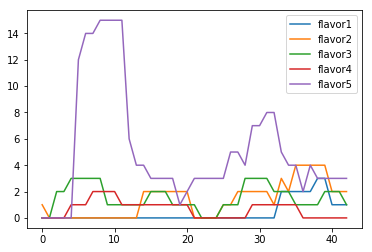

In [6]:
plt.show(request_sum.plot())

In [7]:
print(Est_beg,Est_end)

2015-02-20 00:00:00
 2015-02-27 00:00:00


In [8]:
CleanedTest = File_test.drop('ID', axis=1) # ID number is not a factor
# # Cleaning: drop the requested VM that is not given in input file(need not to predict)
num = (CleanedTest.shape)[0] 
CleanedTest = CleanedTest.drop([i for i in range(num) if CleanedTest['VM'][i] not in VM_type]).reset_index(drop=True)
CleanedTest.groupby(by=['VM'], as_index=False).count()

,VM,Time
0,flavor2,13
1,flavor3,3
2,flavor5,2


In [13]:
request_sum.corr(method='pearson', min_periods = 14)

,flavor1,flavor2,flavor3,flavor4,flavor5
flavor1,1.000000,0.761739,-0.045229,-0.264746,-0.197874
flavor2,0.761739,1.000000,0.038200,-0.229028,-0.327327
flavor3,-0.045229,0.038200,1.000000,0.396036,0.352195
flavor4,-0.264746,-0.229028,0.396036,1.000000,0.700170
flavor5,-0.197874,-0.327327,0.352195,0.700170,1.000000
